In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
# custom scoring
from sklearn import metrics
from sklearn.inspection import permutation_importance
# split test and train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# import library Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabelsML.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinitionML.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabelML.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBooleanML.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominalML.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinalML.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumericML.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

### User function(s)

In [3]:
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel


def datatypeDF(data, databool, datanominal, dataordinal, datanumeric):    
    # initialize variables for all the column name per each datatype
    boolCol = databool.boolean.to_list()
    nominalCol = datanominal.nominal.to_list()
    ordinalCol = dataordinal.ordinal.to_list()
    numericCol = datanumeric.numeric.to_list()

    print('Total Data feature count: ', df.shape[1])
    print(f"\nBoolean feature count: {len(boolCol)}")
    print(f"Nominal feature count: {len(nominalCol)}")
    print(f"Ordinal feature count: {len(ordinalCol)}")
    print(f"Numeric feature count: {len(numericCol)}")
    print('\nTotal feature count: ' ,len(boolCol) + len(nominalCol) + len(ordinalCol) + len(numericCol))

    # return list for each type
    return boolCol, nominalCol, ordinalCol, numericCol

In [4]:
# display labels
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [5]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('TransplantStatus_CAN')
removeCol.remove('TransplantSurvivalDay_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric, df_label = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric, df_label)

Remove row(s) from df_label DataFrame.
Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'GraftFailed_CAN', 'LastFollowupNumber_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 121
Total rows after: 14,856 & columns: 110


In [6]:
# initialize list with feature names
boolCol, nominalCol, ordinalCol, numericCol = datatypeDF(df, df_bool, df_nominal, df_ordinal, df_numeric)

Total Data feature count:  110

Boolean feature count: 9
Nominal feature count: 69
Ordinal feature count: 15
Numeric feature count: 17

Total feature count:  110


In [7]:
# check TransplantSurvivalDay_CAN
df[['TransplantStatus_CAN','TransplantSurvivalDay_CAN']].head()

,TransplantStatus_CAN,TransplantSurvivalDay_CAN
0,False,1411.0
1,True,44.0
2,False,1479.0
3,True,370.0
4,False,1438.0


In [8]:
# describe
df[['TransplantStatus_CAN','TransplantSurvivalDay_CAN']].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TransplantStatus_CAN,14856,2,False,13005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TransplantSurvivalDay_CAN,14856.0,NaN,NaN,NaN,634.23371,473.942355,0.0,194.0,606.0,1084.0,1799.0


In [9]:
from sksurv.util import Surv

# rename columns
df = df.rename(columns={'TransplantStatus_CAN': 'status', 'TransplantSurvivalDay_CAN': 'time'})

# prepare the survival data
y = Surv.from_dataframe('status', 'time', df)
X = df.drop(columns=['status', 'time'])

### Encode

In [10]:
# remove from list
boolCol.remove('TransplantStatus_CAN')
numericCol.remove('TransplantSurvivalDay_CAN')

### Split Testing & Validation & Training

In [11]:
def EncodeDummyScaleTrainValTest(Xdata, ydata, nominalColumns, numericColumns, seed=RANDOM_STATE):

    # dummy Encoding
    df_encoded = pd.get_dummies(Xdata, columns=nominalColumns, drop_first=True)
    
    # split the dataset into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(df_encoded, ydata, test_size=0.2, random_state=seed, stratify=y['status'])
    
    # split train data into validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train['status'])

    # initialize scaling
    scaler = MinMaxScaler()

    # fit model
    fit = scaler.fit(X_train[numericColumns])

    # transform
    X_train[numericColumns] = fit.transform(X_train[numericColumns])
    X_val[numericColumns] = fit.transform(X_val[numericColumns])
    X_test[numericColumns] = fit.transform(X_test[numericColumns])
    
    # display shape
    print(f"Training Dependent Shape: {X_train.shape} & Label Shape: {y_train.shape}")
    print(f"Validation Dependent Shape: {X_val.shape} & Label Shape: {y_val.shape}")
    print(f"Testing Dependent Shape: {X_test.shape} & Label Shape: {y_test.shape}")

    return  X, y, X_train, X_test, X_val, y_train, y_val, y_test

In [12]:
# split dataset
X, y, X_train, X_test, X_val, y_train, y_val, y_test = EncodeDummyScaleTrainValTest(X, y, nominalCol, numericCol, RANDOM_STATE)

Training Dependent Shape: (9507, 204) & Label Shape: (9507,)
Validation Dependent Shape: (2377, 204) & Label Shape: (2377,)
Testing Dependent Shape: (2972, 204) & Label Shape: (2972,)


#### Scoring Custom Function for Survival Analysis

In [13]:
def custom_c_index(y_true, y_pred):
    """
    Calculate the Concordance Index (C-index) for survival analysis.

    Parameters:
    y_true (structured array): True survival times and event indicators.
    y_pred (array-like): Predicted risk scores or survival times.

    Returns:
    float: Concordance Index (C-index).
    """
    # Extract event indicators and survival times
    event_indicators = y_true['status']
    survival_times = y_true['time']
    
    # Calculate the C-index
    c_index = concordance_index_censored(event_indicators, survival_times, y_pred)[0]
    return c_index

# Create the scorer
custom_scorer = metrics.make_scorer(custom_c_index, greater_is_better=True)


In [14]:
def BayesianOptimize(model, Xdata, ydata, search_space, custom_scorer,  n_iter=64, cv=10, seed=RANDOM_STATE):

    # define the K-fold cross-validator
    kfold = KFold(n_splits=cv, shuffle=True, random_state=seed)
    
    # perform Bayesian Optimization with the custom scorer
    opt = BayesSearchCV(estimator=model, search_spaces=search_space, n_iter=n_iter, cv=kfold, n_jobs=-1, scoring=custom_scorer)
    BayesianOpt = opt.fit(Xdata, ydata)
    
    # best model
    Bestmodel = BayesianOpt.best_estimator_
    
    # print the best parameters and best score
    print("Best parameters found: ", BayesianOpt.best_params_)
    print("Best accuracy score: ", BayesianOpt.best_score_)
    
    # display model
    print("\n", Bestmodel)

    return Bestmodel

#### Explanation of the 5 Return Values
##### cindex (float) – Concordance index
- This is a float value between 0 and 1.
    - It represents the proportion of all comparable pairs where the predictions and outcomes are concordant.
    - A value of 1 indicates perfect prediction, 0.5 is no better than random prediction, and 0 is perfectly incorrect prediction
      
##### concordant (int) – Number of concordant pairs
- This is an integer value.
    - It represents the count of pairs where the model's predictions correctly ordered the survival times.
    - A higher number indicates better model performance.

##### discordant (int) – Number of discordant pairs
- This is an integer value.
    - It represents the count of pairs where the model's predictions incorrectly ordered the survival times.
    - A lower number indicates better model performance.

##### tied_risk (int) – Number of pairs having tied estimated risks
- This is an integer value.
    - It represents the count of pairs where the model predicted the same risk score for both samples.
    - Ties in risk scores are handled by adding 0.5 to the concordant count instead of 1.

##### tied_time (int) – Number of comparable pairs sharing the same time
- This is an integer value.
    - It represents the count of comparable pairs that have the same event time.
    - These pairs are not considered in the concordance calculation as they can't be ordered.

##### Interpretation
- The c-index is the primary metric used to evaluate the model's discriminative power. It can be interpreted as the probability that, for a randomly selected pair of subjects, the model correctly orders their survival times.
- The other four values provide additional context about how the c-index was calculated and can be useful for understanding the model's performance in more detail.
    - A high number of concordant pairs relative to discordant pairs indicates good model performance.
    - A large number of tied risk scores might suggest that the model is not sufficiently discriminative.
    - The number of pairs with tied event times gives an indication of the granularity of the time measurements in your dataset.

#### Model Evaluation

In [15]:
# evaluation function
def evaluate_model(model, Xdata, ydata):
    pred = model.predict(Xdata)
    return concordance_index_censored(ydata['status'], ydata['time'], pred)[0]

def SurvivalAnalysisCompare(models, model_names):
    for model, name in zip(models, model_names):
        train_cindex = evaluate_model(model, X_train, y_train)
        val_cindex = evaluate_model(model, X_val, y_val)
        test_cindex = evaluate_model(model, X_test, y_test)
        print(f"{name} - Train C-index: {train_cindex:.4f}, Validation C-index: {val_cindex:.4f}, Test C-index: {test_cindex:.4f}")

#### RandomSurvivalForest


In [16]:
from joblib import Parallel, parallel_backend
    
# define the search space
search_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(1, 6),
    'min_samples_split': Integer(20, 50),
    'max_features': Real(0.01, 1.0, 'log-uniform')
}

# instantiate RandomSurvivalForest (oob_score: whether to use out-of-bag samples to estimate the generalization accuracy.)
model = RandomSurvivalForest(random_state=RANDOM_STATE, n_jobs=-1, oob_score=True)

with parallel_backend('loky', n_jobs=-1):
    # Bayesian Optimization
    rsfModel = BayesianOptimize(model, X_train, y_train, search_space, custom_scorer,  n_iter=32, cv=5, seed=RANDOM_STATE)

Best parameters found:  OrderedDict([('max_depth', 5), ('max_features', 0.04013824402741512), ('min_samples_split', 27), ('n_estimators', 401)])
Best accuracy score:  0.6140798687158944

 RandomSurvivalForest(max_depth=5, max_features=0.04013824402741512,
                     min_samples_split=27, n_estimators=401, n_jobs=-1,
                     oob_score=True, random_state=1776)


#### GradientBoostingSurvivalAnalysis
- `dropout_rate` (float, optional, default: 0.0)
    – If larger than zero, the residuals at each iteration are only computed from a random subset of base learners. The value corresponds to the percentage of base learners that are dropped. In each iteration, at least one base learner is dropped. This is an alternative regularization to shrinkage, i.e., setting learning_rate < 1.0. Values must be in the range [0.0, 1.0).

- `ccp_alpha` (non-negative float, optional, default: 0.0.) 
    – Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. Values must be in the range [0.0, inf).


In [17]:
# define the search space
search_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'max_depth': Integer(1, 5),
    'dropout_rate': Real(0.1, 0.5, 'log-uniform'),
    'ccp_alpha': Real(1e-5, 5, 'log-uniform')
}

# instantiate GradientBoostingSurvivalAnalysis
model = GradientBoostingSurvivalAnalysis(random_state=RANDOM_STATE)

with parallel_backend('loky', n_jobs=-1):
    # Bayesian Optimization
    gbsaModel = BayesianOptimize(model, X_train, y_train, search_space, custom_scorer,  n_iter=32, cv=5, seed=RANDOM_STATE)

Best parameters found:  OrderedDict([('ccp_alpha', 0.00014283669474878083), ('dropout_rate', 0.1), ('learning_rate', 1.0), ('max_depth', 3), ('n_estimators', 492)])
Best accuracy score:  0.6056876769220791

 GradientBoostingSurvivalAnalysis(ccp_alpha=0.00014283669474878083,
                                 dropout_rate=0.1, learning_rate=1.0,
                                 n_estimators=492, random_state=1776)


##### CoxPHSurvivalAnalysis
- `alpha` (float, ndarray of shape (n_features,), optional, default: 0)
    – Regularization parameter for ridge regression penalty. If a single float, the same penalty is used for all features. If an array, there must be one penalty for each feature. If you want to include a subset of features without penalization, set the corresponding entries to 0.

In [18]:
# define the search space
search_space = {
    'alpha': Real(0.01, 10, 'log-uniform'),
    'n_iter': Integer(50, 500),
    'ties': Categorical(['breslow', 'efron']),
    'tol': Real(1e-9, 1e-5, 'log-uniform')
}

# instantiate CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis()

with parallel_backend('loky', n_jobs=-1):
    # Bayesian Optimization
    cphModel = BayesianOptimize(model, X_train, y_train, search_space, custom_scorer,  n_iter=32, cv=5, seed=RANDOM_STATE)

Best parameters found:  OrderedDict([('alpha', 0.15014805617018961), ('n_iter', 500), ('ties', 'efron'), ('tol', 1e-09)])
Best accuracy score:  0.6089350954127882

 CoxPHSurvivalAnalysis(alpha=0.15014805617018961, n_iter=500, ties='efron')


##### Evaluate Model

In [19]:
# evaluate models
models = [rsfModel, gbsaModel, cphModel]
model_names = ['Random Survival Forest', 'Gradient Boosting', 'Cox PH']

# evaluate
SurvivalAnalysisCompare(models, model_names)

Random Survival Forest - Train C-index: 0.7630, Validation C-index: 0.6161, Test C-index: 0.6158
Gradient Boosting - Train C-index: 0.6611, Validation C-index: 0.6295, Test C-index: 0.6054
Cox PH - Train C-index: 0.6696, Validation C-index: 0.5988, Test C-index: 0.6197


##### The Brier score measures the mean squared difference between the predicted survival probabilities and the actual outcomes (event or censored) over time. The Integrated Brier Score (IBS) integrates this measure over the time period, accounting for the entire survival curve rather than just the event time.
- A lower IBS indicates better model performance. IBS is particularly useful for evaluating how well the model predicts survival probabilities across the entire time spectrum, not just the event occurrence.

##### Time-dependent ROC (Receiver Operating Characteristic) curves are used to assess the model’s performance in distinguishing between events and censored observations at different time points. AUC can be computed for each time point, showing how the model performs over time.
- It is commonly used for evaluating classification models for survival data. The AUC value will give an indication of how well the model can distinguish between different survival outcomes at each time point.

##### The calibration plot compares predicted survival probabilities with observed event frequencies. It shows how well the predicted probabilities match the actual event probabilities. The closer the curve is to the diagonal (45-degree line), the better the model’s predictions are calibrated.
- A model is considered well-calibrated if the predicted probabilities of survival match the actual outcomes. It is particularly useful when the model outputs probabilities for survival, not just rankings.

##### The log-rank test is a statistical test used to compare the survival distributions of two or more groups. It assesses whether there are significant differences between the predicted survival times of the model and the observed survival times.
- You would apply this test to check if the survival curves generated by different models (or across different groups) significantly differ.

##### The hazard ratio is a measure of how much the risk of the event (e.g., death, failure) is for one group compared to another. It is typically used in Cox Proportional Hazards models but can also be calculated for any survival model.
- A hazard ratio greater than 1 indicates an increased risk, while a hazard ratio less than 1 indicates a decreased risk. This is useful for assessing the relative risk associated with different predictors or groups.

##### Mean survival time estimates the average time to event across all subjects. This can be helpful when the aim is to provide an overall summary of survival predictions across a population.
- You can compute the mean survival time using the predicted survival functions over time for each individual in the test set.

In [76]:
# Time-dependent ROC Curve (AUC)
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.metrics import brier_score
from lifelines.statistics import logrank_test

In [21]:
def CumulativeDynamicAUC(model, Xtrain, Xval, XTest, ytrain, yval, ytest, Type):
    """
    Cumulative Dynamic Area Under the Curve (cumulative_dynamic_auc) is a performance metric used in time-to-event 
    (survival) analysis. It evaluates the ability of a survival model to discriminate between individuals who 
    experience an event at a given time and those who do not, across various time points.
    
    """
    # predictions
    train_pred = eval(model).predict(Xtrain)
    val_pred = eval(model).predict(Xval)
    test_pred = eval(model).predict(Xtest)
    
    # creating 20 percentile points between the 5th and 95th percentiles of data. 
    # creating a range of evaluation points that cover most of the data while avoiding extreme values.
    times = np.percentile(ytrain['time'][ytrain['status']], np.linspace(5, 95, 20))

    # Cumulative Dynamic Area Under the Curve
    auc_train, mean_auc_train = cumulative_dynamic_auc(ytrain, ytrain, train_pred, times)
    auc_val, mean_auc_val = cumulative_dynamic_auc(ytrain, yval, val_pred, times)
    auc_test, mean_auc_test = cumulative_dynamic_auc(ytrain, ytest, test_pred, times)
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(times, auc_train, marker='o', label='Training')
    plt.plot(times, auc_val, marker='o', label='Validation')
    plt.plot(times, auc_test, marker='o', label='Testing')
    plt.xlabel('Time')
    plt.ylabel('Time-dependent AUC')
    plt.title(f'Time-dependent AUC {Type}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # display
    print(f"Mean AUC (train): {mean_auc_train:.4f}")
    print(f"Mean AUC (validation): {mean_auc_val:.4f}")
    print(f"Mean AUC (test): {mean_auc_test:.4f}")

#### Brier Score

In [93]:
from sklearn.metrics import brier_score_loss



# Predictions
train_pred = rsfModel.predict(X_train)
test_pred = rsfModel.predict(X_test)


# Calculate Brier score for training data
brier_score_train = brier_score_loss(y_train, train_pred)
print(f'Brier score for training data: {brier_score_train}')

# Calculate Brier score for test data
brier_score_test = brier_score_loss(y_test, test_pred)
print(f'Brier score for test data: {brier_score_test}')

ValueError: Only binary classification is supported. The type of the target is multiclass.

This will give you a visual representation of how the model's discriminative ability changes over time for both the training and test sets.
##### Note:
- The AUC values range from 0.5 (random prediction) to 1.0 (perfect prediction).
- If the test AUC is consistently lower than the training AUC, it might indicate overfitting.
- If the AUC decreases over time, it suggests that the model's predictive power diminishes for longer-term predictions.
- This analysis provides valuable insights into the model's performance across different time points in the survival analysis.

In [ ]:

prob_pred = model.predict_proba(X_test)
calibration(y_test, prob_pred)

In [ ]:

results = logrank_test(event_times, group_a, group_b)
print(results)

In [ ]:
mean_survival_time_train = np.mean(train_pred)
mean_survival_time_test = np.mean(test_pred)

In [ ]:
from sklearn.inspection import permutation_importance

def FeatureImportanceRSF(model, Xtrain, Xval, ytrain, yval, nRepeats = 10, seed=RANDOM_STATE):
    
    # Fit the Random Survival Forest model
    fit = eval(model).fit(Xtrain, ytrain)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(fit, Xval, yval, n_repeats=nRepeats, random_state=seed)
    
    # Create a DataFrame with the feature importances
    feature_names = Xtrain.columns  # Assuming X_train is a DataFrame with column names
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean
    })
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the permutation feature importances with feature names
    plt.figure(figsize=(20, 10))  # Corrected: added closing parenthesis
    plt.bar(importance_df['Feature'], importance_df['Importance'])
    plt.title('Random Survival Forest Feature Importances (Permutation)')
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=90, fontsize=6)

    # Add feature names to the x-axis
    feature_names = Xtrain.columns
    plt.xticks(range(Xtrain.shape[1]), feature_names, rotation=90, fontsize=6)
    
    plt.tight_layout() 
    plt.show()
    
    # Return the DataFrame
    return importance_df

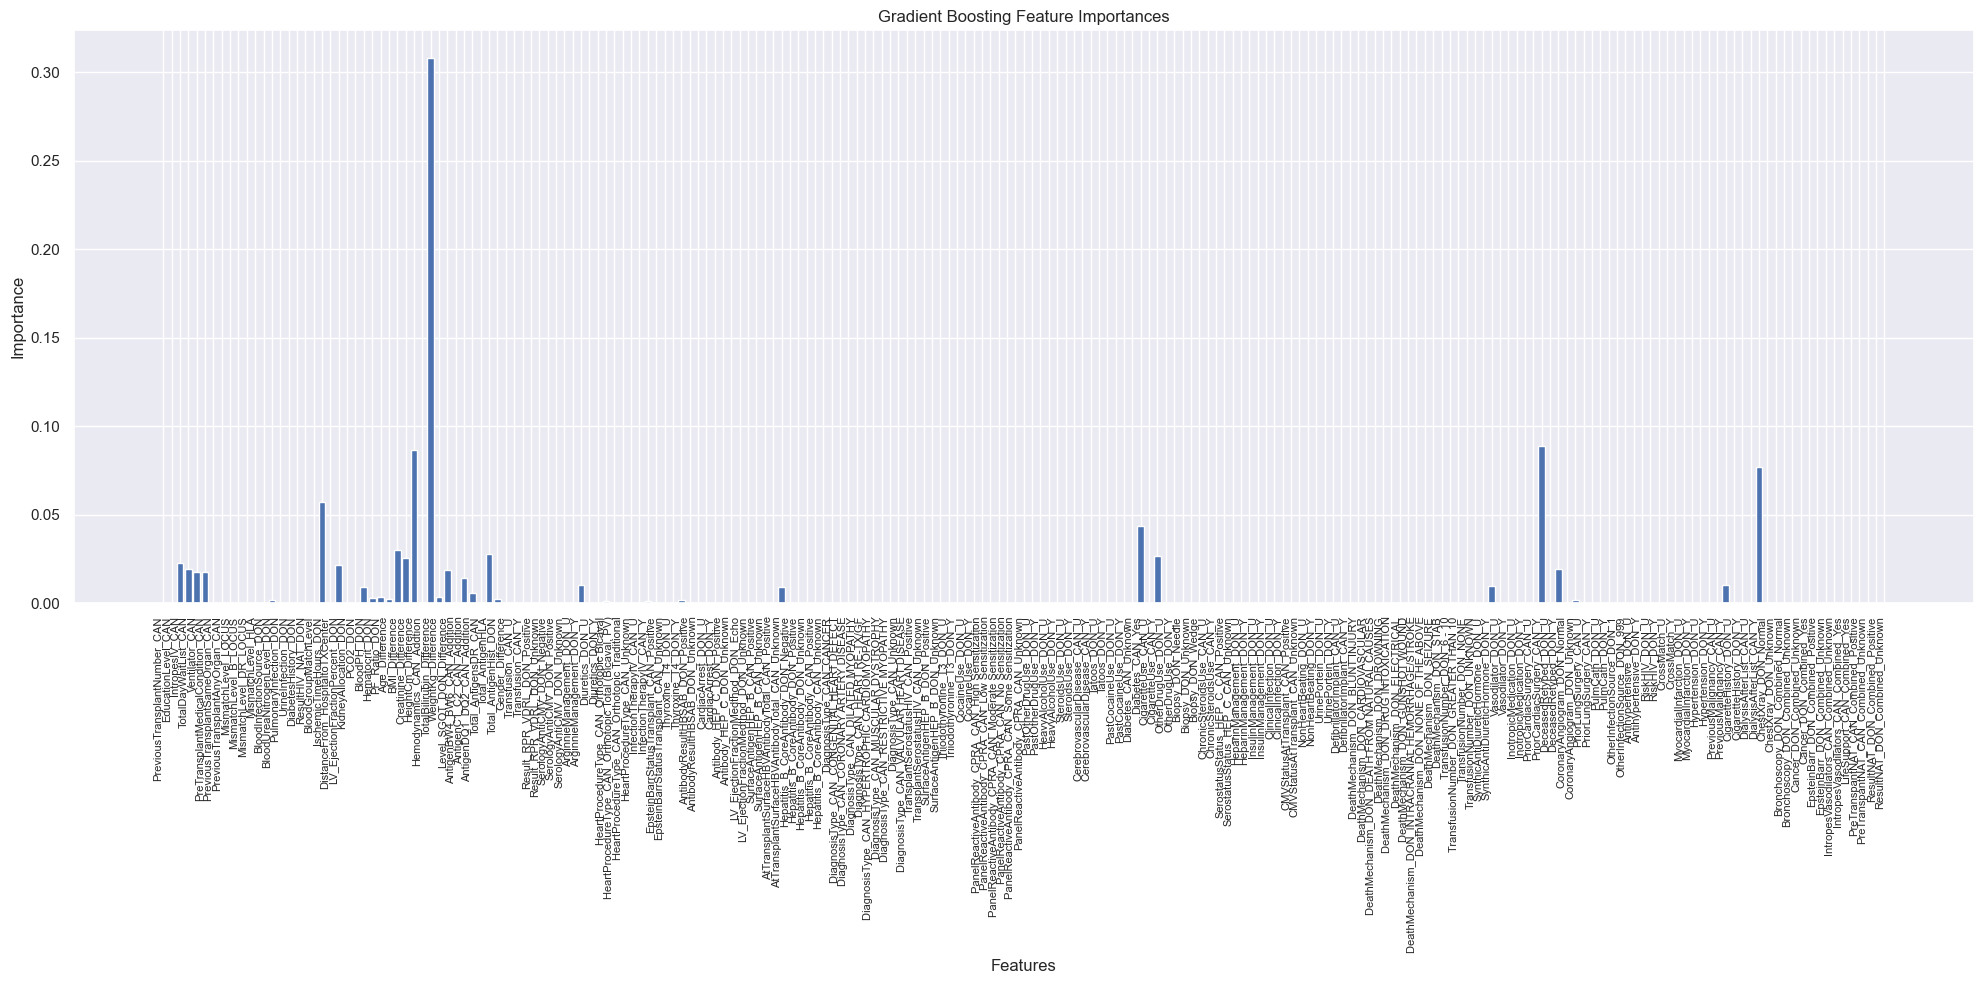

In [22]:
# Assuming X_train is a DataFrame
feature_names = X_train.columns

plt.figure(figsize=(20, 10))
plt.bar(feature_names, gbsaModel.feature_importances_)
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate feature names for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

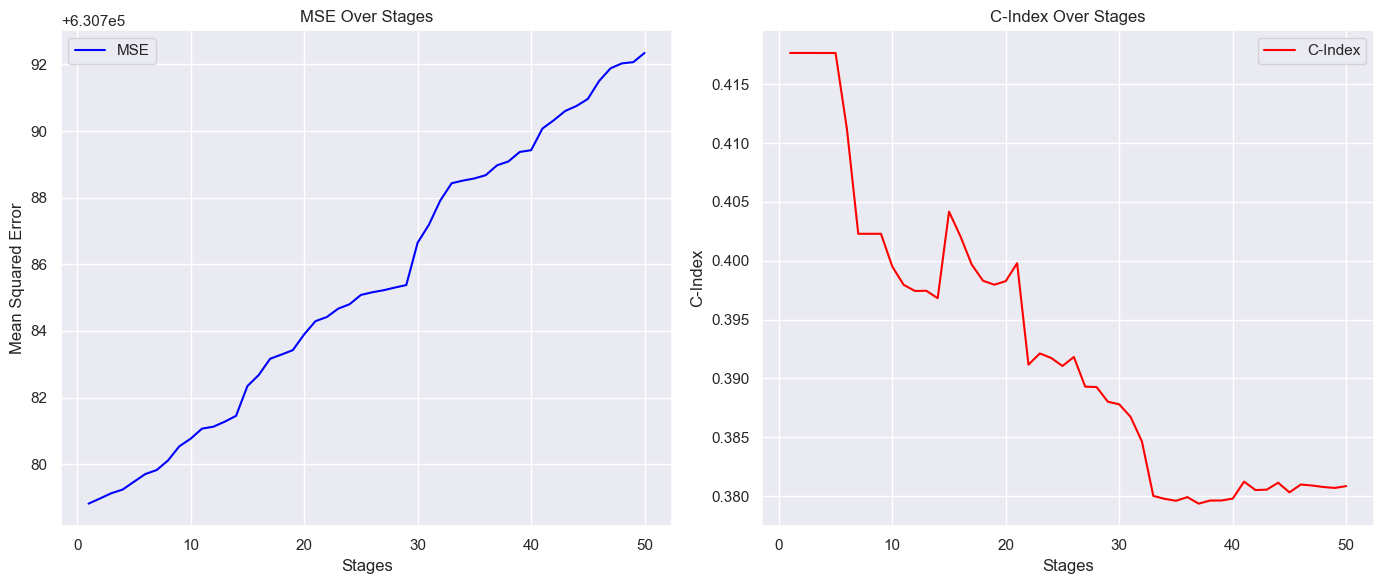

In [25]:
modelPerformance(X_test, y_test, gbsaModel)

In [24]:
def modelPerformance(Xdata, ydata, model):
    # Lists to store the metrics at each stage
    mse_list = []
    c_index_list = []
    
    # Loop through each stage and compute performance on the validation set
    for stage_pred in model.staged_predict(Xdata):
        # Calculate MSE
        mse = metrics.mean_squared_error(y_test['time'], stage_pred)
        mse_list.append(mse)
        
        # Calculate C-Index
        c_index = concordance_index_censored(
            ydata['status'], 
            ydata['time'], 
            -stage_pred  # Use negative predictions for survival analysis
        )[0]  # Extract the C-Index score
        c_index_list.append(c_index)
    
    # Plotting the MSE and C-Index over stages
    stages = range(1, len(mse_list) + 1)
    plt.figure(figsize=(14, 6))
    
    # MSE Plot
    plt.subplot(1, 2, 1)
    plt.plot(stages, mse_list, label='MSE', color='blue')
    plt.xlabel('Stages')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE Over Stages')
    plt.legend()
    
    # C-Index Plot
    plt.subplot(1, 2, 2)
    plt.plot(stages, c_index_list, label='C-Index', color='red')
    plt.xlabel('Stages')
    plt.ylabel('C-Index')
    plt.title('C-Index Over Stages')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

##### Interpreting the Plots Together:
- Both C-Index Increases and MSE Decreases: This is the ideal case, suggesting the model is both ranking risks accurately and predicting times with higher precision.
- High C-Index but High MSE: This indicates the model ranks individuals well in terms of risk but struggles to predict exact event times accurately. This may be acceptable for some survival tasks where ranking is more important than exact predictions.
- Low C-Index with Decreasing MSE: Suggests the model is predicting event times better but may not rank risks accurately, which could reduce the model's utility in survival scenarios where ranking is essential.
- Both C-Index and MSE Plateau or Increase: Indicates the model may be overfitting, capturing noise instead of meaningful patterns. This might mean that the model’s current complexity is too high or that more data preprocessing is required.

##### C-Index value range:
- The C-Index ranges from 0 to 1.
    - C-Index = 0.5: This is the baseline value, indicating no better than random guessing. The model does not differentiate between events well.
    - C-Index = 1.0: This is the perfect value, indicating that the model ranks all pairs of individuals exactly in the correct order.
    - C-Index < 0.5: This suggests that the model is worse than random, which might indicate an issue with the model or how it's trained.

In [34]:
gbsaModel.train_score_

array([8741.64757103, 8727.3119777 , 8720.76114268, 8713.90360647,
       8708.00214543, 8695.21080989, 8685.61447666, 8677.62141506,
       8676.80106769, 8670.70456564, 8660.85845634, 8658.65128761,
       8654.27529099, 8649.7993576 , 8643.71088568, 8639.21888235,
       8652.77589769, 8648.84224261, 8640.14750429, 8638.40007472,
       8630.73959886, 8641.95561093, 8630.84172485, 8628.17572045,
       8627.93016872, 8625.58065334, 8635.71270145, 8626.69907568,
       8620.7500611 , 8615.34151105, 8611.50126293, 8607.90801187,
       8624.93741226, 8610.41216785, 8620.39308894, 8611.59536548,
       8609.66660447, 8606.23151779, 8606.86649753, 8605.00578903,
       8611.02588454, 8621.12113621, 8618.93131394, 8609.17037177,
       8600.87552468, 8613.10930007, 8607.02629151, 8611.72767714,
       8605.12972803, 8595.34566778])

In [46]:
 gbsaModel.n_estimators 

1

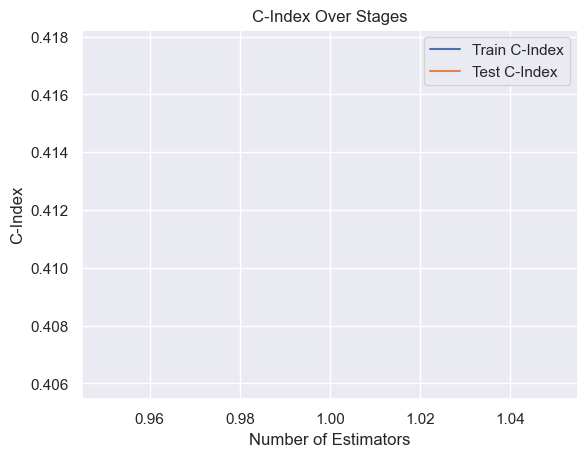

In [39]:
# Initialize lists to store performance metrics
train_c_index_list = []
test_c_index_list = []

# Evaluate performance at each stage
for stage in range(1, gbsaModel.n_estimators + 1):
    gbsaModel.set_params(n_estimators=stage)
    gbsaModel.fit(X_train, y_train)
    
    # Predictions
    train_pred = gbsaModel.predict(X_train)
    test_pred = gbsaModel.predict(X_test)
    
    # Calculate C-Index for train and test sets
    train_c_index = concordance_index_censored(y_train["status"], y_train["time"], -train_pred)[0]
    test_c_index = concordance_index_censored(y_test["status"], y_test["time"], -test_pred)[0]
    
    train_c_index_list.append(train_c_index)
    test_c_index_list.append(test_c_index)


plt.plot(range(1, len(train_c_index_list) + 1), train_c_index_list, label="Train C-Index")
plt.plot(range(1, len(test_c_index_list) + 1), test_c_index_list, label="Test C-Index")
plt.xlabel("Number of Estimators")
plt.ylabel("C-Index")
plt.title("C-Index Over Stages")
plt.legend()
plt.show()

In [47]:
# Assuming 'gbsaModel' is your fitted model and 'X_train' is your training dataset (DataFrame)
feature_importances = gbsaModel.feature_importances_

# Create a DataFrame with feature names and their corresponding importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
32,TotalBilirubin_Difference,0.486566
165,PriorCardiacSurgery_CAN_Y,0.148175
191,DialysisAfterList_CAN_Y,0.114229
30,HeightCm_Difference,0.095120
5,PreTransplantMedicalCondition_CAN,0.088553
24,BloodPH_DON,0.067356
141,DefibrillatorImplant_CAN_U,0.000000
133,ClinicalInfection_DON_U,0.000000
134,ClinicalInfection_DON_Y,0.000000
135,CMVStatusAtTransplant_CAN_Positive,0.000000


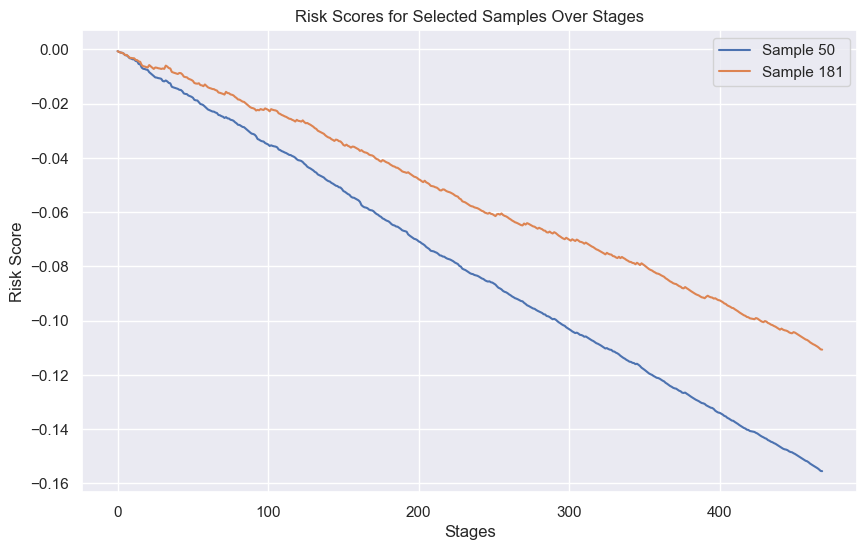

In [80]:
sample_indices = [50, 181] 
staged_predictions = []

# iterate each stage
for stage_pred in gbsaModel.staged_predict(X_test[selected]):
    # Append predictions for the selected samples
    staged_predictions.append(stage_pred[sample_indices])

# convert to array for easier plotting
staged_predictions = np.array(staged_predictions) 

# plot the predictions for each selected sample
plt.figure(figsize=(10, 6))
for i, idx in enumerate(sample_indices):
    plt.plot(staged_predictions[:, i], label=f'Sample {idx}')

plt.xlabel('Stages')
plt.ylabel('Risk Score')
plt.title('Risk Scores for Selected Samples Over Stages')
plt.legend()
plt.show()

In [ ]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index


# Initialize the model (Cox Proportional Hazards model from lifelines)
model = CoxPHFitter()

# Store metrics to track over epochs
train_losses = []
val_losses = []
c_index_train = []
c_index_val = []

# Number of epochs for training (replace with actual number for your case)
epochs = 100

for epoch in range(epochs):
    # Fit the model on the training data (no step_size argument)
    model.fit(X_train, duration_col='time', event_col='event')

    # Predict risk scores for both training and validation set
    train_preds = model.predict_partial_hazard(X_train)
    val_preds = model.predict_partial_hazard(X_test)

    # Calculate C-Index for training and validation
    c_index_train_epoch = concordance_index(y_train['time'], train_preds, event_observed=y_train['event'])
    c_index_val_epoch = concordance_index(y_test['time'], val_preds, event_observed=y_test['event'])

    # Store the C-Index values
    c_index_train.append(c_index_train_epoch)
    c_index_val.append(c_index_val_epoch)

    # Optional: Calculate validation loss if needed (using MSE as an example)
    val_loss = np.mean((val_preds - y_test['time'])**2)
    val_losses.append(val_loss)

    # Optional: Print the C-Index and Loss values
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch + 1}/{epochs}: Train C-Index = {c_index_train_epoch:.4f}, Val C-Index = {c_index_val_epoch:.4f}, Val Loss = {val_loss:.4f}")

# Plot C-Index and Loss values for training and validation sets over epochs
plt.figure(figsize=(12, 6))

# Plot C-Index
plt.subplot(1, 2, 1)
plt.plot(range(epochs), c_index_train, label='Train C-Index')
plt.plot(range(epochs), c_index_val, label='Validation C-Index')
plt.title('C-Index Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('C-Index')
plt.legend()

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def SurvivalAnalysisCompare(model, Xtrain, Xtest, ytrain, ytest, txt = ''):

    # predictions for training and test sets
    preds_train = model.predict(Xtrain)  # risk scores or survival predictions
    preds_test = model.predict(Xtest)

    # calculate C-Index for the model using the correct function from sksurv
    cindex_train, concordant_train, discordant_train, tied_risk_train, tied_time_train = concordance_index_censored(ytrain["status"], ytrain["time"], preds_train)
    cindex_test, concordant_test, discordant_test, tied_risk_test, tied_time_test = concordance_index_censored(ytest["status"], ytest["time"], preds_test)
    
    # display
    print(f"\n{txt} Training:")
    print(f"{txt} C-Index: {cindex_train:.5f}")
    print(f"{txt} Number of concordant pairs: {concordant_train:,}")
    print(f"{txt} Number of discordant pairs: {discordant_train:,}")
    print(f"{txt} Number of pairs having tied estimated risks: {tied_risk_train:,}")
    print(f"{txt} Number of comparable pairs sharing the same time: {tied_time_train:,}")
    print(f"\n{txt} Testing:")
    print(f"{txt} C-Index: {cindex_test:.5f}")
    print(f"{txt} Number of concordant pairs: {concordant_test:,}")
    print(f"{txt} Number of discordant pairs: {discordant_test:,}")
    print(f"{txt} Number of pairs having tied estimated risks: {tied_risk_test:,}")
    print(f"{txt} Number of comparable pairs sharing the same time: {tied_time_test:,}")  